In [1]:
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential, load_model, Model, Input
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, InputLayer, ZeroPadding2D, GlobalAvgPool2D, Reshape, Softmax
from keras.datasets import cifar10
from keras.applications.mobilenet import MobileNet
from keras.utils import np_utils
import matplotlib.pyplot as plt
from skimage.transform import resize


%matplotlib inline

/Users/Beebs/miniconda3/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Load Data: (32,32,3) Images

In [4]:
#  This tutorial attempts to achieve transfer learning on incompatible image sizes with MobileNet.
#  Why do this, when we could just load a different (compatible) data set, or use a different model?
#  Because!  Well, this is a tutorial, and it illustrates the practical issues of transfer learning.


(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#  Check shapes.

In [ ]:
#  Convince yourself that the labels are consistent with the data.  
#  See https://www.cs.toronto.edu/~kriz/cifar.html
print(y_train[7])   
plt.imshow(x_train[4999])

## Resize

In [ ]:
%%time

#  Resize.
#  One option to deal with the fact that MobileNet does not like (32,32,3) shape is to resize the images.
#  NOTE:  On my machine, resizing the entire training data set would take, according to my precise calculations, a very long time.
#  I will only be resizing and training on 5,000 (about 50 minutes for me), creating a 2 gig file.  
#  You will have to do this on your own, I will not include the resized file on github (although it is possible to host large files).

#  Base case.


resized_train_data = []
resized_train_data = np.reshape(np.append(resized_train_data, resize(x_train[0],(128,128,3))),(128,128,3))

#  Change range to 50000 if you want to do the entire set.  NOT RECOMMENDED


for row in range(5000):
    if row > 0:
        resized = resize(x_train[row],(128,128,3))
        resized_train_data = np.reshape(np.append(resized_train_data, resized),((row+1),128,128,3))
          

In [ ]:
plt.imshow(resized_train_data[4999])

In [30]:
#  Also resize test data
resized_test_data = []
resized_test_data = np.reshape(np.append(resized_test_data, resize(x_test[0],(128,128,3))),(128,128,3))

for row in range(1000):
    if row > 0:
        resized = resize(x_test[row],(128,128,3))
        resized_test_data = np.reshape(np.append(resized_test_data, resized),((row+1),128,128,3))
          


/Users/Beebs/miniconda3/envs/keras/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


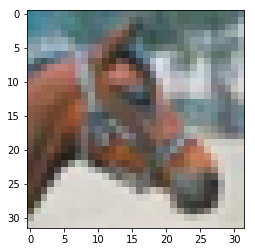

In [37]:
plt.imshow(x_test[17])

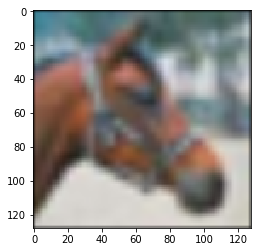

In [38]:
plt.imshow(resized_test_data[17])

### Save/Load

In [ ]:
#np.save('resized_5k_images.npy',resized_train_data)


In [ ]:
#load_resized = np.load('resized_5k_images.npy')

#  Or, alternately if you saved as .npz
with np.load('/Users/Beebs/Desktop/resized_5k_images.npz') as data:
    load_resized = data['arr_0']

In [ ]:
#  Check
load_resized.shape

## Clean Data:  Binary Reps. of Categories, Unrolling, Scaling

In [5]:
x_train_unrolled = x_train.reshape(-1,32*32*3) / 256

#Reshape for convolutions
x_train_reshape = x_train.reshape(-1,32,32,3) / 256
print(x_train_reshape.shape)
#print(x_train_unrolled.shape)
y_train_encoded = np_utils.to_categorical(y_train)
print(y_train_encoded.shape)

x_test_unrolled = x_test.reshape(-1,32*32*3) / 256
y_test_encoded = np_utils.to_categorical(y_test)

(50000, 32, 32, 3)
(50000, 10)


In [7]:
#  Grab relevant number of labels.
fivek_labels = y_test_encoded[:5000]
fivek_labels.shape

(5000, 10)

## Create Unbiased Conv. NN

In [13]:
#  With the resized images, we can use them for MobileNet.  
#  Otherwise, it would throw an error that the input_shape is too small.

fresh = MobileNet(input_shape=(128,128,3),include_top =True, weights=None,classes=10)
fresh.summary()
len(fresh.layers)
fresh.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [14]:
%%time
history_fresh = fresh.fit(load_resized,fivek_labels,epochs = 5,batch_size=1)

Epoch 1/5
5000/5000 [==============================] - 922s 184ms/step - loss: 2.4690 - acc: 0.1016
Epoch 2/5
5000/5000 [==============================] - 957s 191ms/step - loss: 2.3692 - acc: 0.0958
Epoch 3/5
5000/5000 [==============================] - 997s 199ms/step - loss: 2.3246 - acc: 0.1004
Epoch 4/5
5000/5000 [==============================] - 934s 187ms/step - loss: 2.3113 - acc: 0.0984
Epoch 5/5
5000/5000 [==============================] - 953s 191ms/step - loss: 2.3062 - acc: 0.0984
CPU times: user 2h 48min 45s, sys: 53min 37s, total: 3h 42min 22s
Wall time: 1h 19min 26s


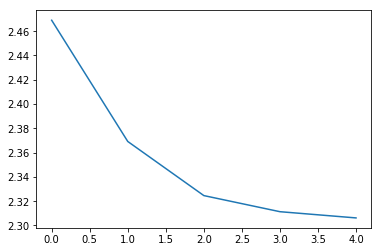

In [20]:
plt.plot(history_fresh.history['loss'])
#plt.plot(history_fresh.history['acc'])

## Add Adapters for Data Dimensions

## Fit and Plot

## Create Biased Conv. NN

In [ ]:
# Pretrained weights only exist for certain shapes, which is why we get an error with smaller image sizes.
# We will use the weights anyways for this tutorial, but try loading other data sets with compatible image sizes.
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
for layer in trained_model.layers:
    layer.trainable = False

#Check number of trainable parameters after freezing layers.
trained_model.summary()
#trained_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
%%time
transfer_model.fit(fivek_resized,fivek_labels,epochs=10,batch_size=4)

In [ ]:
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet')
transfer_model = Sequential()
transfer_model.layers.extend(trained_model.layers[1:])

#Freeze: keep some pre-trained weights as they are.
#Try freezing other layers.
#for layer in trained_model.layers:
#    layer.trainable = False



In [9]:
#  Since we are doing a more complex model, we use the functional API Model() class from keras.
#  We manually describe the inputs and outputs.
#  For this MobileNet object, we will need to chop off the classification layers when 
#  using pre-trained weights.    
    
#  Create tensor object.
inputs = Input(shape = (128,128,3)) 

    #transfer_model = Sequential()
    #transfer_model = Sequential([Input(shape = (128,128,3))]) 
    #transfer_model.layers.extend(trained_model.layers[1:])


#  
trained_model = MobileNet(input_shape = (128,128,3),include_top = False, weights='imagenet', input_tensor = inputs)

#  Freeze: keep pre-trained weights as they are.
#  Check number of trainable parameters in summary after freezing layers.
for layer in trained_model.layers:
    layer.trainable = False

#  We can just plug the biased model into a layer.
#x = trained_model(inputs)

#  Then, if we want we can copy as close as possible the 
#  structure of the layers removed by include_top=False.

x = GlobalAvgPool2D(data_format='channels_last')(trained_model.output)
x = Reshape((1,1,-1))(x)
x = Dropout(rate=0.001)(x)
x = Conv2D(filters=10,kernel_size=(1,1))(x)
x = Activation(activation = 'softmax')(x)
predictions = Reshape((-1,))(x)


transferable_model = Model(inputs = inputs,outputs = predictions)
transferable_model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
transferable_model.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 130, 130, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 66, 66, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
__________

In [11]:
history_transfer = transferable_model.fit(load_resized,fivek_labels,epochs=5,batch_size=1)

Epoch 1/5
5000/5000 [==============================] - 212s 42ms/step - loss: 2.8646 - acc: 0.0950
Epoch 2/5
5000/5000 [==============================] - 198s 40ms/step - loss: 2.7516 - acc: 0.1182
Epoch 3/5
5000/5000 [==============================] - 199s 40ms/step - loss: 2.6758 - acc: 0.1478
Epoch 4/5
5000/5000 [==============================] - 271s 54ms/step - loss: 2.6029 - acc: 0.1514
Epoch 5/5
5000/5000 [==============================] - 224s 45ms/step - loss: 2.5581 - acc: 0.1696


## Fit

In [ ]:
%%time
history_transfer = transfer_model.fit(x_train_unrolled,y_train_encoded,epochs=15)

## Compare 

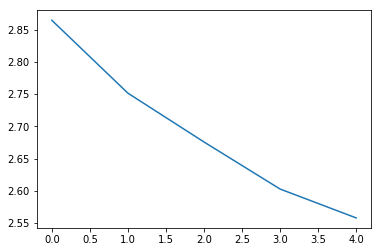

In [12]:
plt.plot(history_transfer.history['loss'])

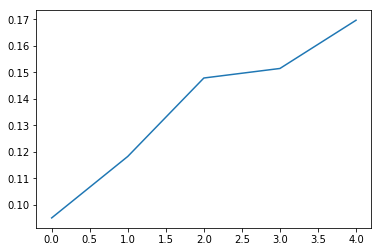

In [22]:
plt.plot(history_transfer.history['acc'])

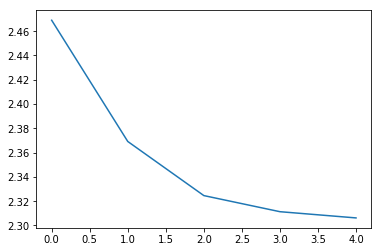

In [21]:
#  Compare with plots from unbiased network.
plt.plot(history_fresh.history['loss'])

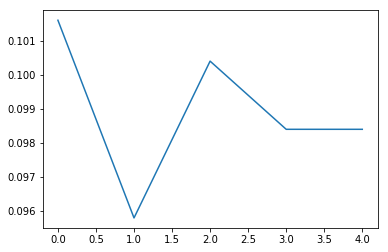

In [23]:
plt.plot(history_fresh.history['acc'])

## Prediction and Scoring

In [39]:
#  Supress scientific notation for easier comparison.
np.set_printoptions(suppress=True)

#  Predict a class and look at an example to compare between biased and unbiased.
#  What do you expect the comparison to show?
unbiased_prediction = fresh.predict(resized_test_data)




0.9999999925494194

In [42]:
unbiased_prediction[72]

array([0.09971654, 0.09949561, 0.10231756, 0.10204754, 0.10073467,
       0.10044523, 0.09825634, 0.09878521, 0.10071333, 0.09748793],
      dtype=float32)

In [40]:
#  Note: predict gives us probabilities like predict_proba for other models.  Check that they sum to one.
sum(unbiased_prediction[72])

0.999999962747097

In [41]:
biased_prediction = transferable_model.predict(resized_test_data)
biased_prediction[72]

array([0.00270297, 0.6011381 , 0.00442038, 0.31289887, 0.00635025,
       0.06648728, 0.00062809, 0.0020399 , 0.00204786, 0.00128624],
      dtype=float32)

In [43]:
#  True label:
y_test_encoded[72]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [53]:
#  Unbiased
#  Brier score, lower is better: smaller distance between prediction and true label.  
#  Try looking at prediction scores before and after training.
unbiased_diff = y_test_encoded[:1000] - unbiased_prediction
score_u = np.sum((1/1000)*(np.power(unbiased_diff,2)),axis=1)

#Overall score for 1000 test examples.
sum(score_u)

0.9000755808872435

In [54]:
#  Biased
biased_diff = y_test_encoded[:1000] - biased_prediction  
score_b = np.sum((1/1000)*(np.power(biased_diff,2)),axis=1)

sum(score_b)

1.2000418282114584

In [51]:
score_u[0]

0.0008952628018522481

In [52]:
score_b[0]

0.0012866036333145036